# Commmunity Analysis

### Importing libraries

In [1]:
import networkx as nx
import numpy as np
from networkx.algorithms.community.quality import modularity
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import re


First, we will inspect the network

### Loading the graph

In [2]:
# Load graph and make undirected
G = nx.read_graphml("data/world_graph_attributes.graphml")
G = G.to_undirected()

In [3]:
print(len(G.nodes()))
for node, data in G.nodes(data=True):
    print(node, data)

192
Afghanistan {'sentiment_score': 2.6, 'gdp': 502.115}
China {'sentiment_score': 5.4, 'gdp': 14244.678}
Egypt {'sentiment_score': 4.1, 'gdp': 3020.031}
France {'sentiment_score': 5.5, 'gdp': 40493.929}
Germany {'sentiment_score': 5.0, 'gdp': 46258.878}
India {'sentiment_score': 6.1, 'gdp': 1910.836}
Iran {'sentiment_score': 5.0, 'gdp': 5371.177}
Italy {'sentiment_score': 6.0, 'gdp': 33189.566}
Pakistan {'sentiment_score': 5.0, 'gdp': 1405.581}
Qatar {'sentiment_score': 6.4, 'gdp': 64781.733}
Russia {'sentiment_score': 4.2, 'gdp': 11774.156}
United_Kingdom {'sentiment_score': 6.0, 'gdp': 42300.267}
United_States {'sentiment_score': 5.6, 'gdp': 65280.682}
Uzbekistan {'sentiment_score': 4.2, 'gdp': 1724.841}
Albania {'sentiment_score': 4.8, 'gdp': 5352.857}
Bosnia_and_Herzegovina {'sentiment_score': 4.2, 'gdp': 6073.265}
Bulgaria {'sentiment_score': 5.7, 'gdp': 12328.404}
Greece {'sentiment_score': 6.4, 'gdp': 19582.536}
Ireland {'sentiment_score': 4.8, 'gdp': 77629.989}
Montenegro {'se

### Forming Louvain Communities

In [4]:
# Building the Louvain partition using NetworkX's built-in function (define a seed for reproducibility)
louvain_communities = nx.community.louvain_communities(G, seed = 10)
print(f"Total communities formed using Louvain method: {len(louvain_communities)}\n")


for i, community in enumerate(louvain_communities):
    print(f"Louvain Community {i+1} (n = {len(community)}): {list(community)[:5]}")
print("---")

Total communities formed using Louvain method: 5

Louvain Community 1 (n = 23): ['Qatar', 'Tunisia', 'Saudi_Arabia', 'Jordan', 'Iraq']
Louvain Community 2 (n = 34): ['Saint_Kitts_and_Nevis', 'Trinidad_and_Tobago', 'El_Salvador', 'Belize', 'United_States']
Louvain Community 3 (n = 51): ['Sierra_Leone', 'Cape_Verde', 'Comoros', 'Liberia', 'The_Gambia']
Louvain Community 4 (n = 46): ['Croatia', 'Germany', 'Ukraine', 'Poland', 'Kyrgyzstan']
Louvain Community 5 (n = 38): ['Tuvalu', 'Bangladesh', 'Malaysia', 'Maldives', 'Japan']
---


# Communities by attribute partitions

In [5]:
def classify_nodes_by_attribute(G, attribute, k=3):
    """
    Returns a dictionary mapping class_label -> list_of_nodes.
    The attribute has a higher value in the the higher levels.
    """

    # Collect values only from nodes that have the attribute (can be erased once the network is perfect)
    #values = []
    #nodes_with_attr = []
#
    #for n, data in G.nodes(data=True):
    #    if attribute not in data:
    #        print(f"Node '{n}' is missing attribute '{attribute}' — skipping.")
    #        continue
#
    #    # Extract attribute values
    #    values.append(data[attribute])
    #    nodes_with_attr.append(n)

    # Store the values
    #vals = np.array(values)
    vals = np.array([G.nodes[n][attribute] for n in G.nodes])

    #Use log to colapse the scale 
    vals = np.log(vals + 1) 

    # Compute partition boundaries
    bins = np.linspace(vals.min(), vals.max(), k + 1)

    # Create labels: Level_1, Level_2, ..., Level_k
    labels = [f"Level_{i+1}" for i in range(k)]

    # Prepare output dictionary
    classes = {label: [] for label in labels}

    # Assign nodes to classes
    for node, data in G.nodes(data=True):
        value = data.get(attribute)

        # Skip if missing
        if value is None:
            print(f"Node {node} has no attribute '{attribute}'")
            continue

        # Determine the partition index
        idx = np.digitize(value, bins) - 1 
        # clamp to valid range 
        idx = min(max(idx, 0), k-1)        

        classes[labels[idx]].append(node)

    return classes


In [6]:
def classify_nodes_by_attribute(G, attribute, k=3):
    """
    Classify countries into k levels based on the log of the attribute.
    """
    # extract attribute values
    vals = []
    for n in G.nodes:
        if attribute in G.nodes[n]:
            vals.append(G.nodes[n][attribute])

    vals = np.array(vals)

    # log-transform
    log_vals = np.log(vals + 1)

    # compute bins on log scale
    bins = np.linspace(log_vals.min(), log_vals.max(), k + 1)

    labels = [f"Level_{i+1}" for i in range(k)]
    classes = {label: [] for label in labels}

    # Assign nodes to classes
    for node, data in G.nodes(data=True):
        value = data.get(attribute)

        if value is None:
            print(f"Node {node} has no attribute '{attribute}'")
            continue

        # log-transform the node value too
        log_value = np.log(value + 1)

        idx = np.digitize(log_value, bins) - 1
        idx = min(max(idx, 0), k - 1)

        classes[labels[idx]].append(node)

    return classes


### Forming communities by language

Now we will try to form communities based on language. Does not work now with the new network (does not have language). 

In [187]:
# Build communities by language
language_communities = {}

for node, data in G.nodes(data=True):
    language = data.get("official_language") 

    # skip nodes with missing values
    if language is None:
        print("Node with no language")
        print(node)
        continue

    language_communities[language] = node

Node with no language
Afghanistan
Node with no language
China
Node with no language
Egypt
Node with no language
France
Node with no language
Germany
Node with no language
India
Node with no language
Iran
Node with no language
Italy
Node with no language
Pakistan
Node with no language
Qatar
Node with no language
Russia
Node with no language
United_Kingdom
Node with no language
United_States
Node with no language
Uzbekistan
Node with no language
Albania
Node with no language
Bosnia_and_Herzegovina
Node with no language
Bulgaria
Node with no language
Greece
Node with no language
Ireland
Node with no language
Montenegro
Node with no language
Serbia
Node with no language
Spain
Node with no language
Algeria
Node with no language
Iceland
Node with no language
Jordan
Node with no language
Lebanon
Node with no language
Libya
Node with no language
Mali
Node with no language
Malta
Node with no language
Mauritania
Node with no language
Morocco
Node with no language
Netherlands
Node with no languag

In [149]:
for lang, members in language_communities.items():
    print(f"Language: {lang} ({len(members)} nodes)")
    print(members[:10], "...\n")

### Forming community by GDP

I will now create the divisions of GDP and the sentiment score. We will consider 3 levels: 1, 2 and 3. A function will be developed that does that to use for the various attributes more easily. 

In [7]:
gdp_partitions = classify_nodes_by_attribute(G,'gdp', k=6)

In [8]:
print(len(gdp_partitions["Level_1"]), "elements")
print(len(gdp_partitions["Level_1"]))

21 elements
21


In [9]:
print(len(gdp_partitions["Level_2"]), "elements")
print(len(gdp_partitions["Level_2"]))

34 elements
34


In [10]:
print(len(gdp_partitions["Level_3"]))

49


### Forming communities by History Sentiment Score

In [11]:
sentiment_partitions = classify_nodes_by_attribute(G, "sentiment_score", k=6)

In [12]:
print(len(sentiment_partitions["Level_1"]), "elements")
sentiment_partitions["Level_1"][:5] # TO SHOW


3 elements


['Afghanistan', 'Haiti', 'South_Sudan']

In [13]:
print(len(sentiment_partitions["Level_2"]), "elements")
sentiment_partitions["Level_2"][:5] # TO SHOW

9 elements


['Mali', 'Yemen', 'Democratic_Republic_of_the_Congo', 'Burundi', 'Sudan']

In [14]:
print(len(sentiment_partitions["Level_2"]), "elements")
sentiment_partitions["Level_3"][:5] # TO SHOW

9 elements


['Egypt', 'Russia', 'Uzbekistan', 'Bosnia_and_Herzegovina', 'Lebanon']

#### Forming community by continent (by hand because it is not a network attribute right now)

In [188]:
CONTINENTS = {
    "Africa": [
        "Algeria","Angola","Benin","Botswana","Burkina_Faso","Burundi",
        "Cameroon","Cape_Verde","Central_African_Republic","Chad","Comoros",
        "Congo","Democratic_Republic_of_the_Congo","Djibouti","Egypt",
        "Equatorial_Guinea","Eritrea","Eswatini","Ethiopia","Gabon",
        "Gambia","Ghana","Guinea","Guinea-Bissau","Ivory_Coast","Kenya",
        "Lesotho","Liberia","Libya","Madagascar","Malawi","Mali",
        "Mauritania","Mauritius","Morocco","Mozambique","Namibia","Niger",
        "Nigeria","Republic_of_the_Congo","Rwanda","São_Tomé_and_Príncipe",
        "Senegal","Seychelles","Sierra_Leone","Somalia","South_Africa",
        "South_Sudan","Sudan","Tanzania","The_Gambia","Togo","Tunisia",
        "Uganda","Zambia","Zimbabwe"
    ],

    "Asia": [
        "Afghanistan","Armenia","Azerbaijan","Bahrain","Bangladesh",
        "Bhutan","Brunei","Cambodia","China","Cyprus","Georgia","India",
        "Indonesia","Iran","Iraq","Israel","Japan","Jordan","Kazakhstan",
        "Kuwait","Kyrgyzstan","Laos","Lebanon","Malaysia","Maldives",
        "Mongolia","Myanmar","Nepal","North_Korea","Oman","Pakistan",
        "Philippines","Qatar","Saudi_Arabia","Singapore","South_Korea",
        "Sri_Lanka","Syria","Tajikistan","Thailand","Timor-Leste",
        "Turkey","Turkmenistan","United_Arab_Emirates","Uzbekistan",
        "Vietnam","Yemen"
    ],

    "Europe": [
        "Albania","Andorra","Austria","Belarus","Belgium","Bosnia_and_Herzegovina",
        "Bulgaria","Croatia","Czech_Republic","Denmark","Estonia","Finland",
        "France","Germany","Greece","Hungary","Iceland","Ireland","Italy",
        "Kazakhstan","Kosovo","Latvia","Liechtenstein","Lithuania","Luxembourg",
        "Malta","Moldova","Monaco","Montenegro","Netherlands","North_Macedonia",
        "Norway","Poland","Portugal","Romania","Russia","San_Marino","Serbia",
        "Slovakia","Slovenia","Spain","Sweden","Switzerland","Ukraine",
        "United_Kingdom"
    ],

    "North_America": [
        "Antigua_and_Barbuda","Bahamas","Barbados","Belize","Canada","Costa_Rica",
        "Cuba","Dominica","Dominican_Republic","El_Salvador","Grenada","Guatemala",
        "Haiti","Honduras","Jamaica","Mexico","Nicaragua","Panama",
        "Saint_Kitts_and_Nevis","Saint_Lucia","Saint_Vincent_and_the_Grenadines",
        "The_Bahamas","Trinidad_and_Tobago","United_States"
    ],

    "South_America": [
        "Argentina","Bolivia","Brazil","Chile","Colombia","Ecuador","Guyana",
        "Paraguay","Peru","Suriname","Uruguay","Venezuela"
    ],

    "Oceania": [
        "Australia","Fiji","Kiribati","Marshall_Islands","Micronesia","Nauru",
        "New_Zealand","Palau","Papua_New_Guinea","Samoa","Solomon_Islands",
        "Tonga","Tuvalu","Vanuatu"
    ]
}


In [190]:
continent_communities = {}

COUNTRY_TO_CONTINENT = {}
for cont, countries in CONTINENTS.items():
    for c in countries:
        COUNTRY_TO_CONTINENT[c] = cont

for node in G.nodes():
    if node not in COUNTRY_TO_CONTINENT:
        print("⚠ Country not assigned:", node)
        continue

    cont = COUNTRY_TO_CONTINENT[node]
    continent_communities.setdefault(cont, []).append(node)


# Analysing the communities

### Visualizing the commmunity graphs

Visualizing the communities for GDP, Louvain, and Sentiment partitions...



NameError: name 'louvain_modularity' is not defined

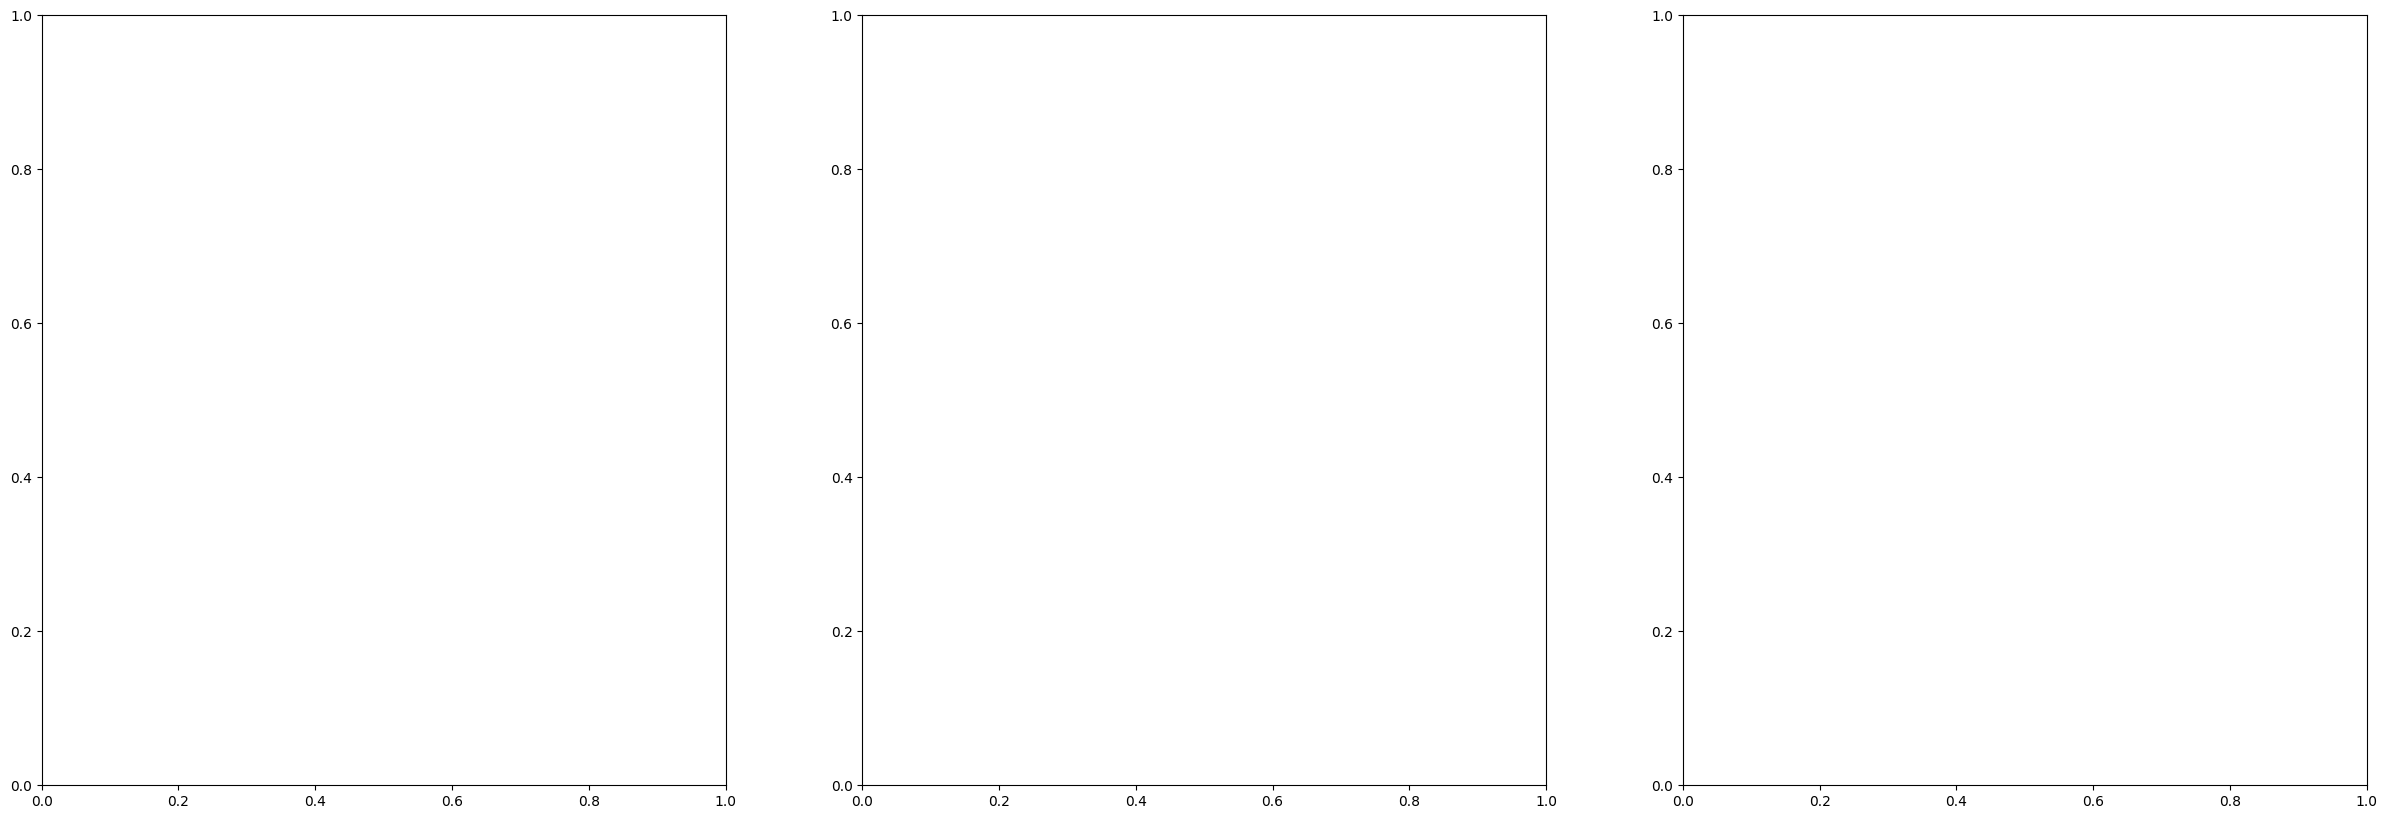

In [15]:
# Visualizing the communities for GDP, Louvain, and Sentiment partitions
print("Visualizing the communities for GDP, Louvain, and Sentiment partitions...\n")

fig, axes = plt.subplots(1, 3, figsize=(30, 10))
pos = nx.spring_layout(G, seed=42)

# GDP partition colors
gdp_levels = list(gdp_partitions.keys())
gdp_colors = []
for node in G.nodes():
    for idx, level in enumerate(gdp_levels):
        if node in gdp_partitions[level]:
            gdp_colors.append(idx)
            break

# Louvain partition colors
louvain_colors = []
for node in G.nodes():
    for idx, community in enumerate(louvain_communities):
        if node in community:
            louvain_colors.append(idx)
            break

# Sentiment partition colors
sentiment_levels = list(sentiment_partitions.keys())
sentiment_colors = []
for node in G.nodes():
    for idx, level in enumerate(sentiment_levels):
        if node in sentiment_partitions[level]:
            sentiment_colors.append(idx)
            break

# 1. Louvain communities
axes[0].set_title(f"Louvain Communities\n(Modularity={louvain_modularity:.3f})", fontsize=22)
nx.draw_networkx_nodes(G, pos, node_size=80, node_color=louvain_colors, cmap=plt.cm.viridis, ax=axes[0])
nx.draw_networkx_edges(G, pos, alpha=0.1, ax=axes[0])
axes[0].axis("off")

# 2. GDP communities
axes[1].set_title(f"GDP Level Communities\n(Modularity={gdp_modularity:.3f})", fontsize=22)
nx.draw_networkx_nodes(G, pos, node_size=80, node_color=gdp_colors, cmap=plt.cm.viridis, ax=axes[1])
nx.draw_networkx_edges(G, pos, alpha=0.1, ax=axes[1])
axes[1].axis("off")

# 3. Sentiment communities
axes[2].set_title(f"Sentiment Score Communities\n(Modularity={sentiment_modularity:.3f})", fontsize=22)
nx.draw_networkx_nodes(G, pos, node_size=80, node_color=sentiment_colors, cmap=plt.cm.viridis, ax=axes[2])
nx.draw_networkx_edges(G, pos, alpha=0.1, ax=axes[2])
axes[2].axis("off")

plt.tight_layout()
plt.show()

### Calculating the Modularity of the different partitions

Modularity (GDP partitions): 0.0410
Modularity (Sentiment partitions): 0.0128
Modularity (Louvain communities): 0.3660



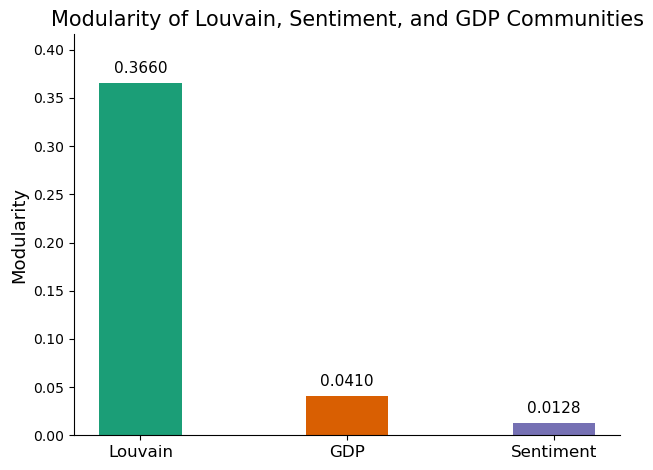

In [208]:
# Calculate modularity for GDP partitions
gdp_modularity = modularity(G, gdp_partitions.values())
print(f"Modularity (GDP partitions): {gdp_modularity:.4f}")

# Calculate modularity for sentiment partitions
sentiment_modularity = modularity(G, sentiment_partitions.values())
print(f"Modularity (Sentiment partitions): {sentiment_modularity:.4f}")

# Calculate modularity for Louvain communities
louvain_modularity = modularity(G, louvain_communities)
print(f"Modularity (Louvain communities): {louvain_modularity:.4f}\n")

# Plot the modularity values for comparison with improved colors
labels = ['Louvain', 'GDP', 'Sentiment']
modularity_values = [louvain_modularity, gdp_modularity, sentiment_modularity]
x = np.arange(len(labels))
width = 0.4

# Use more distinct and colorblind-friendly colors
bar_colors = ['#1b9e77', '#d95f02', '#7570b3']

fig, ax = plt.subplots()
bars = ax.bar(x, modularity_values, width, color=bar_colors, linewidth=1.2)
ax.set_ylabel('Modularity', fontsize=13)
ax.set_title('Modularity of Louvain, Sentiment, and GDP Communities', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.set_ylim(0, max(modularity_values) + 0.05)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11)

sns.despine()
plt.tight_layout()
plt.show()


### Visualization of the Matrix _D_

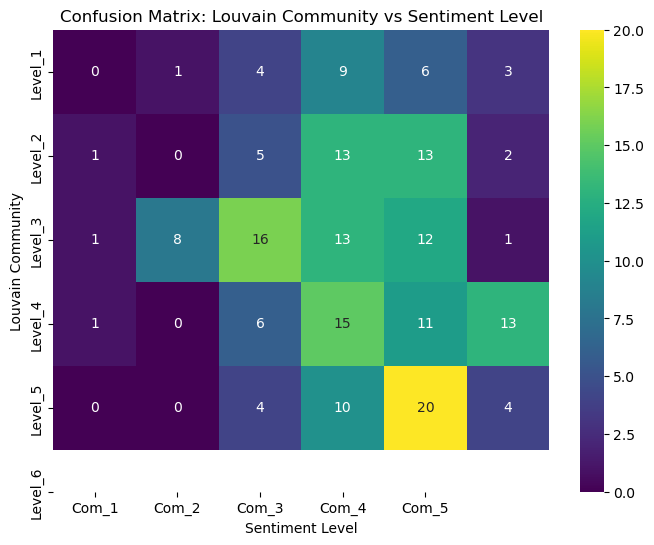

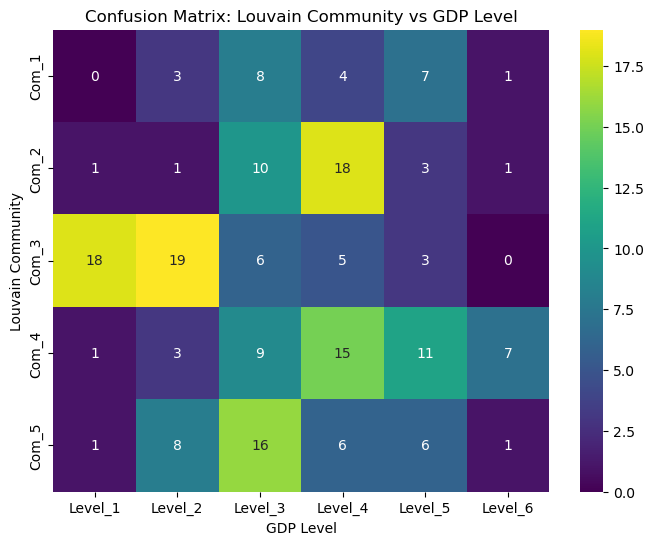

In [209]:
# Louvain x Sentiment confusion matrix
louvain_count = len(louvain_communities)
sentiment_count = len(sentiment_levels)
louvain_sentiment_matrix = np.zeros((louvain_count, sentiment_count), dtype=int)

for i, comm in enumerate(louvain_communities):
    comm_set = set(comm)
    for j, sentiment_level in enumerate(sentiment_levels):
        sentiment_set = set(sentiment_partitions[sentiment_level])
        louvain_sentiment_matrix[i, j] = len(comm_set & sentiment_set)

plt.figure(figsize=(8, 6))
sns.heatmap(
    louvain_sentiment_matrix, annot=True, fmt='d', cmap='viridis',
    xticklabels=[f'Com_{i+1}' for i in range(louvain_count)],
    yticklabels=sentiment_levels
)
plt.title("Confusion Matrix: Louvain Community vs Sentiment Level")
plt.xlabel("Sentiment Level")
plt.ylabel("Louvain Community")
plt.show()

# Louvain x GDP confusion matrix
gdp_count = len(gdp_levels)
louvain_gdp_matrix = np.zeros((louvain_count, gdp_count), dtype=int)

for i, comm in enumerate(louvain_communities):
    comm_set = set(comm)
    for j, gdp_level in enumerate(gdp_levels):
        gdp_set = set(gdp_partitions[gdp_level])
        louvain_gdp_matrix[i, j] = len(comm_set & gdp_set)

plt.figure(figsize=(8, 6))
sns.heatmap(
    louvain_gdp_matrix, annot=True, fmt='d', cmap='viridis',
    xticklabels=gdp_levels,
    yticklabels=[f'Com_{i+1}' for i in range(louvain_count)]
)
plt.title("Confusion Matrix: Louvain Community vs GDP Level")
plt.xlabel("GDP Level")
plt.ylabel("Louvain Community")
plt.show()


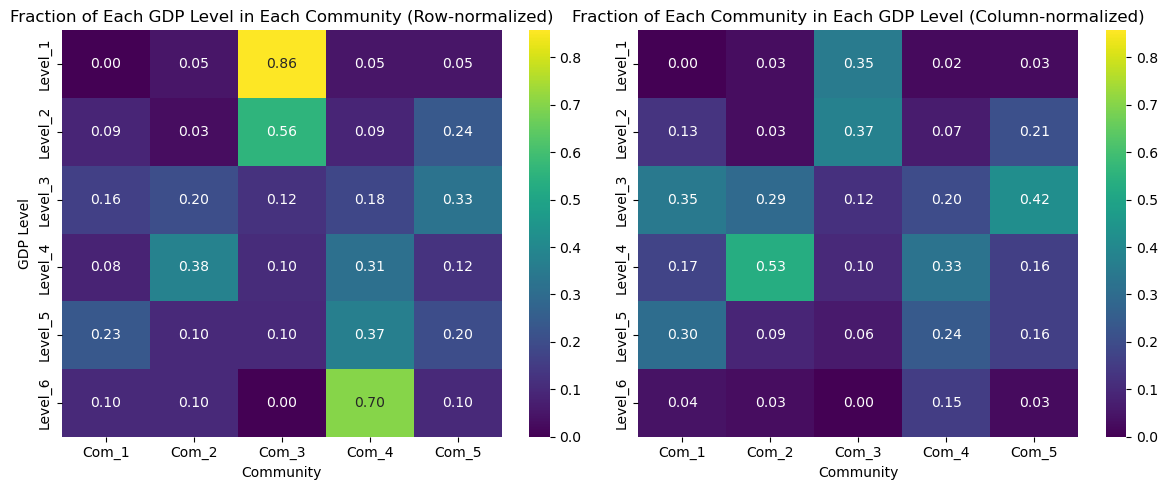

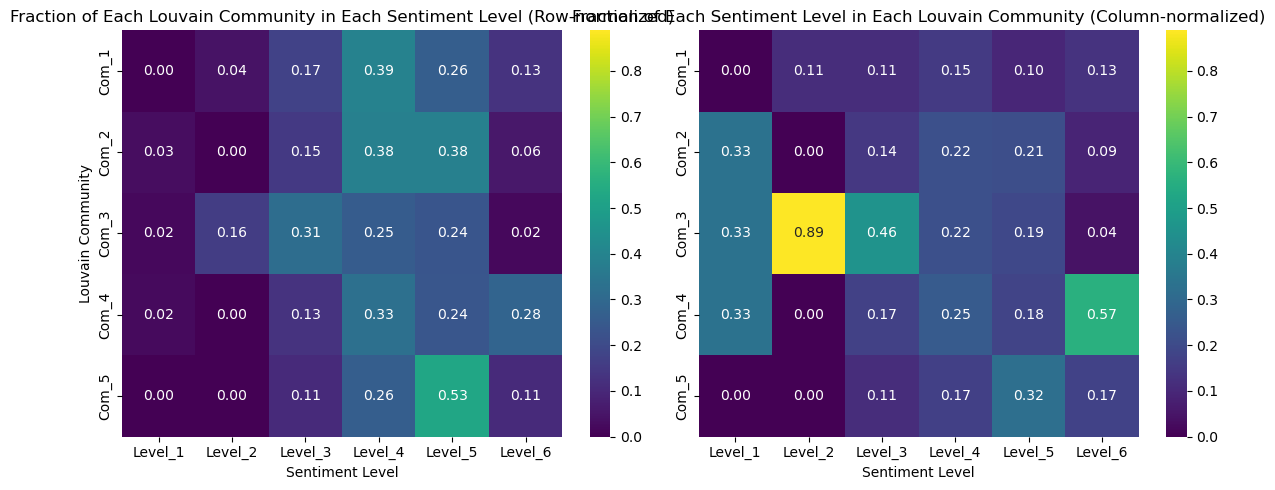

In [211]:
# Row-normalized and column-normalized heatmaps for GDP x Louvain (already present)
cont_table = conf_matrix

row_norm = cont_table / cont_table.sum(axis=1, keepdims=True)
col_norm = cont_table / cont_table.sum(axis=0, keepdims=True)

vmax = max(row_norm.max(), col_norm.max())
vmin = min(row_norm.min(), col_norm.min())

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(row_norm, annot=True, fmt='.2f',
            yticklabels=gdp_levels, xticklabels=[f'Com_{i+1}' for i in range(cont_table.shape[1])],
            cmap='viridis', vmin=vmin, vmax=vmax)
plt.title('Fraction of Each GDP Level in Each Community (Row-normalized)')
plt.xlabel('Community'); plt.ylabel('GDP Level')

plt.subplot(1,2,2)
sns.heatmap(col_norm, annot=True, fmt='.2f',
            yticklabels=gdp_levels, xticklabels=[f'Com_{i+1}' for i in range(cont_table.shape[1])],
            cmap='viridis', vmin=vmin, vmax=vmax)
plt.title('Fraction of Each Community in Each GDP Level (Column-normalized)')
plt.xlabel('Community'); plt.ylabel('')
plt.tight_layout()
plt.show()

# Now for Sentiment x Louvain
cont_table2 = louvain_sentiment_matrix

row_norm2 = cont_table2 / cont_table2.sum(axis=1, keepdims=True)
col_norm2 = cont_table2 / cont_table2.sum(axis=0, keepdims=True)

vmax2 = max(row_norm2.max(), col_norm2.max())
vmin2 = min(row_norm2.min(), col_norm2.min())

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(row_norm2, annot=True, fmt='.2f',
            yticklabels=[f'Com_{i+1}' for i in range(cont_table2.shape[0])], xticklabels=sentiment_levels,
            cmap='viridis', vmin=vmin2, vmax=vmax2)
plt.title('Fraction of Each Louvain Community in Each Sentiment Level (Row-normalized)')
plt.xlabel('Sentiment Level'); plt.ylabel('Louvain Community')

plt.subplot(1,2,2)
sns.heatmap(col_norm2, annot=True, fmt='.2f',
            yticklabels=[f'Com_{i+1}' for i in range(cont_table2.shape[0])], xticklabels=sentiment_levels,
            cmap='viridis', vmin=vmin2, vmax=vmax2)
plt.title('Fraction of Each Sentiment Level in Each Louvain Community (Column-normalized)')
plt.xlabel('Sentiment Level'); plt.ylabel('')


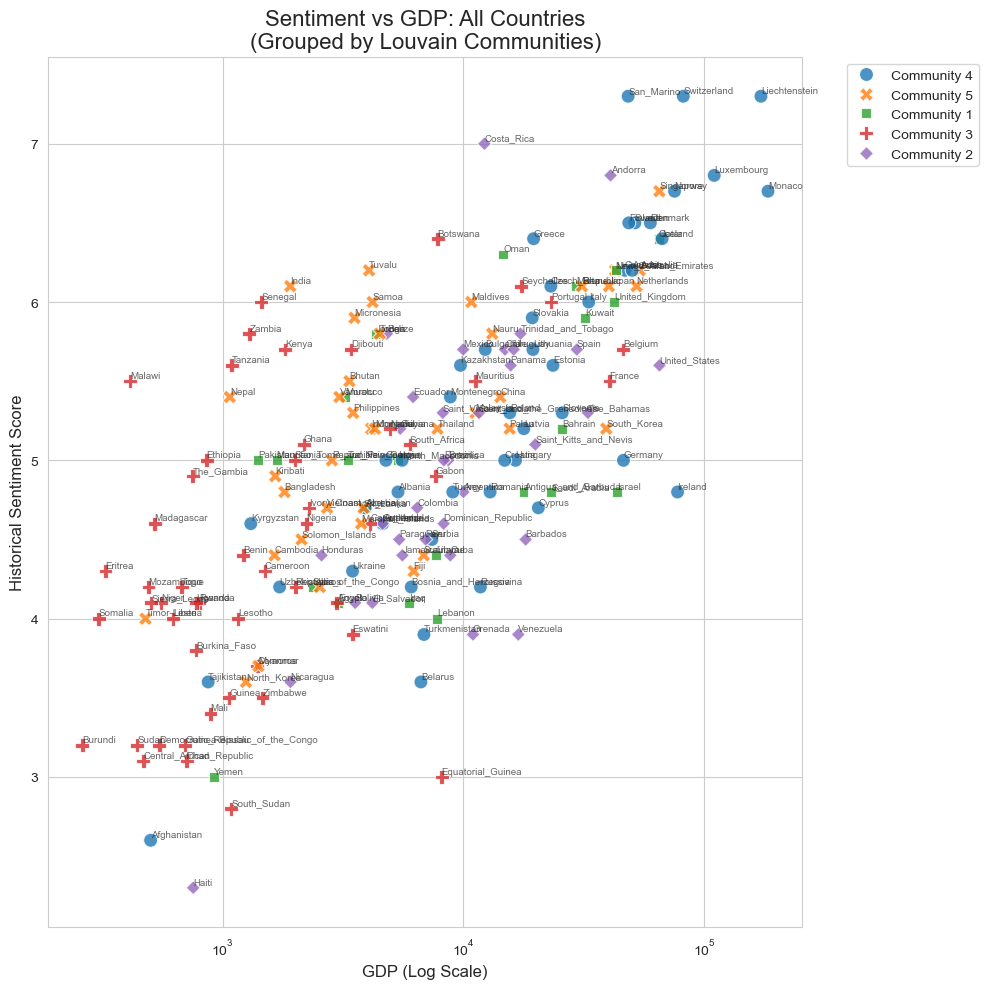

3. POLARIZATION SCORES (Standard Deviation of Sentiment):
Higher score = Stronger evidence for your 'Happy vs Sad' theory
------------------------------------------------------------
     Community  Polarization_Score
0  Community 4            1.073225
1  Community 3            0.952573
2  Community 2            0.907294
3  Community 1            0.871712
4  Community 5            0.773094


In [ ]:
sns.set_style("whitegrid")

# PLOT: GDP vs SENTIMENT (All Countries)
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=df,
    x="GDP",
    y="Sentiment",
    hue="Community",
    style="Community",
    s=100,
    palette="tab10",
    alpha=0.8
)
# Annotate ALL points
for i in range(df.shape[0]):
    plt.text(
        x=df.GDP.iloc[i],
        y=df.Sentiment.iloc[i] + 0.02,  # Slight vertical offset
        s=df.Country.iloc[i],
        fontsize=7,  # Adjusted down to 7 for better density
        alpha=0.7
    )
plt.xscale('log')
plt.title("Sentiment vs GDP: All Countries\n(Grouped by Louvain Communities)", fontsize=16)
plt.xlabel("GDP (Log Scale)", fontsize=12)
plt.ylabel("Historical Sentiment Score", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

# --- ANALYTICAL METHOD 2: GDP vs SENTIMENT DIVERGENCE ---
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x="GDP",
    y="Sentiment",
    hue="Community",
    style="Community",
    s=150,
    palette="tab10"
)
# Annotate all points with country names
for i in range(df.shape[0]):
    plt.text(
        df.GDP.iloc[i] + 1000,
        df.Sentiment.iloc[i],
        df.Country.iloc[i],
        fontsize=9,
        alpha=0.8
    )
plt.xscale('log')
plt.title("2. The Divergence Test: Sentiment vs GDP\n(All countries shown, colored by community)", fontsize=15)
plt.xlabel("GDP (Log Scale)")
plt.ylabel("Sentiment Score")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

# --- ANALYTICAL METHOD 3: VARIANCE/INEQUALITY SCORE ---
# Calculate standard deviation of sentiment per community
variance_df = df.groupby('Community')['Sentiment'].std().sort_values(ascending=False).reset_index()
variance_df.columns = ['Community', 'Polarization_Score']
print("3. POLARIZATION SCORES (Standard Deviation of Sentiment):")
print("Higher score = Stronger evidence for your 'Happy vs Sad' theory")
print("-" * 60)
print(variance_df)


Results of TF-IDF are not making much sense right now. I believe considering GDP per capita will result in a better behaviour. 

# TF-IDF 

In [215]:
import os
import math
import random
import string
import pickle as pkl
from io import StringIO
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


This function will be used to eliminate the countries names from the countries wikipages. We will also try to eliminate nationalities. 

In [216]:
countries = list(G.nodes())

In [ ]:
NATIONALITIES = [
    "Afghan", "Albanian", "Algerian", "American", "Andorran", "Angolan",
    "Antiguan", "Argentine", "Armenian", "Australian", "Austrian",
    "Azerbaijani", "Bahamian", "Bahraini", "Bangladeshi", "Barbadian",
    "Belarusian", "Belgian", "Belizean", "Beninese", "Bhutanese",
    "Bolivian", "Bosnian", "Botswanan", "Brazilian", "British", "Bruneian",
    "Bulgarian", "Burkinabe", "Burmese", "Burundian", "Cambodian",
    "Cameroonian", "Canadian", "Cape Verdean", "Central African",
    "Chadian", "Chilean", "Chinese", "Colombian", "Comorian",
    "Congolese", "Costa Rican", "Croatian", "Cuban", "Cypriot",
    "Czech", "Danish", "Djiboutian", "Dominican", "Dutch",
    "East Timorese", "Ecuadorian", "Ecuadorean",
    "Egyptian", "Emirati", "English", "Equatoguinean",
    "Eritrean", "Estonian", "Ethiopian", "Fijian", "Filipino",
    "Philippine",  # added
    "Finnish", "French", "Gabonese", "Gambian", "Georgian", "German",
    "Ghanaian", "Greek", "Grenadian", "Guatemalan", "Guinean",
    "Guyanese", "Haitian", "Honduran", "Hungarian", "Icelandic",
    "Indian", "Indonesian", "Iranian", "Iraqi", "Irish",
    "Israeli", "Italian", "Jamaican", "Japanese", "Jordanian",
    "Kazakh", "Kenyan", "Kiribati", "Kittitian", "Korean", "Kosovar",
    "Kuwaiti", "Kyrgyz", "Lao", "Latvian", "Lebanese", "Liberian",
    "Libyan", "Liechtensteiner", "Lithuanian", "Luxembourger", "Luxembourgish",
    "Macedonian", "Macedonia",  # added
    "Malagasy", "Malawian", "Malaysian", "Maldivian", "Malian",
    "Maltese", "Marshallese", "Mauritanian", "Mauritian", "Mexican",
    "Micronesian", "Moldovan", "Monacan", "Mongolian", "Montenegrin",
    "Moroccan", "Mozambican", "Namibian", "Nauruan", "Nepalese",
    "New Zealander", "Nicaraguan", "Nigerian", "Nigerien", "Niuean",
    "Norwegian", "Omani", "Pakistani", "Palauan", "Panamanian",
    "Papua New Guinean", "Paraguayan", "Peruvian", "Polish",
    "Portuguese", "Qatari", "Romanian", "Russian", "Rwandan",
    "Salvadoran", "Sammarinese", "Samoan", "Saudi", "Scottish",
    "Senegalese", "Serbian", "Seychellois", "Sierra Leonean",
    "Singaporean", "Slovak", "Slovenian", "Slovene",  # added
    "Somali", "South African", "South Sudanese", "Spanish",
    "Sri Lankan", "Sudanese", "Surinamese", "Swazi", "Swedish",
    "Swiss", "Syrian", "Taiwanese", "Tajik", "Tanzanian", "Thai",
    "Togolese", "Tongan", "Trinidadian", "Tunisian", "Turkish",
    "Turkmen", "Tuvaluan", "Ugandan", "Ukrainian", "Uruguayan",
    "Uzbek", "Vanuatuan", "Venezuelan", "Vietnamese", "Welsh",
    "Yemeni", "Zambian", "Zimbabwean",
    # historical demonyms:
    "Czechoslovakian", "Transjordanian", "Burman", "Burmese",
]

EXTRA_COUNTRIES = [
    "Burma",
    "Macedonia",
    "Czechoslovakia",
    "Transjordan",
    "Nubia",
    "Anatolia",
    "Bosnia",
    "Bahamas",
    "Trinidad",
    "Tobago",
    "Herzegovina",
    "Congo",
    "Saint",
    "Vincent",
    "Grenadines",
    "Korea"
]

country_list = countries + EXTRA_COUNTRIES



In [235]:
import re
from pathlib import Path

def clean_countries_and_nationalities(
    source_folder,
    dest_folder,
    country_list,
    nationalities
):
    source = Path(source_folder)
    dest = Path(dest_folder)
    dest.mkdir(parents=True, exist_ok=True)

    # Prepare country names 
    cleaned_countries = [
        c.replace("_", " ").title() for c in country_list
    ]

    country_terms = []

    for c in cleaned_countries:
        country_terms.append(c)          
        country_terms.append(c.lower())  
        country_terms.append(c + "s")        
        country_terms.append(c.lower() + "s")  

    # Prepare nationalities 
    nationality_terms = []

    for nat in nationalities:
        singular_title = nat
        singular_lower = nat.lower()
        plural_title = nat + "s"
        plural_title = nat + "es"
        plural_lower = nat.lower() + "s"

        nationality_terms.extend([
            singular_title,
            singular_lower,
            plural_title,
            plural_lower,
        ])


    # Build final regex
    all_terms = country_terms + nationality_terms

    # Escape and join terms
    pattern = re.compile(
        r"\b(" + "|".join(map(re.escape, all_terms)) + r")\b",
        flags=re.IGNORECASE
    )

    # Process files
    for file in source.glob("*.txt"):
        text = file.read_text(encoding="utf-8")
        cleaned = pattern.sub("", text)
        (dest / file.name).write_text(cleaned, encoding="utf-8")


In [236]:
clean_countries_and_nationalities(
    source_folder="countries_pages",
    dest_folder="countries_cleaned_plus_nationalities",
    country_list=country_list,
    nationalities=NATIONALITIES,
)

Now we will start with the TF-IDF functions. 

In [120]:
# initialize the list of common English stopwords and a lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_tokenize(text, rare_threshold=None): #optimized
    """
    Improved tokenizer for historical/narrative TF-IDF analysis.
    - lowercase
    - remove punctuation/numbers
    - lemmatize
    - remove stopwords AFTER lemmatization
    - optional rare filtering at global level (NOT per document)
    """

    # lowercase
    text = text.lower()

    # remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", " ", text)

    # tokenize
    tokens = text.split()

    # lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # remove stopwords (after lemmatization)
    tokens = [t for t in tokens if t not in stop_words]

    # remove very short tokens
    tokens = [t for t in tokens if len(t) > 2]

    # Does not remove rare words because they might be important in historical context
    if rare_threshold:
        freq = Counter(tokens)
        tokens = [t for t in tokens if freq[t] >= rare_threshold]

    return tokens

In [ ]:
def clean_tokenize_bigram(text):
    """
    Tokenizer that returns only bigrams.
    - Lowercase
    - Remove punctuation and numbers
    - Lemmatize unigrams
    - Remove stopwords
    - Build bigrams after cleaning
    """

    # lowercase
    text = text.lower()

    # remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", " ", text)

    # split into unigrams
    tokens = text.split()

    # lemmatize unigrams
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # remove stopwords (after lemmatization)
    tokens = [t for t in tokens if t not in stop_words]

    # remove very short tokens
    tokens = [t for t in tokens if len(t) > 2]

    # build bigrams
    bigrams = [tokens[i] + "_" + tokens[i+1] for i in range(len(tokens)-1)]

    return bigrams


In [121]:
# initialize the list of common English stopwords and a lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_tokenize_unigram(text, rare_threshold=5):
    """
    Clean, tokenize, and lemmatize a text string.
    - Lowercase
    - Remove punctuation and numbers
    - Remove stopwords
    - Lemmatize words
    - Filter out rare words (freq < rare_threshold)

    Parameters:
    text: str
        Text being clean 
    rare_threshold: int
        Minimum number of times a word needs to appear in a text to be considered

    Returns
    tokens : list of str
        List of cleaned, lemmatized tokens that occur at least
        'rare_threshold' times in the text.
    """
    # lowercase
    text = text.lower()

    # remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", "", text)

    # tokenize (split on whitespace)
    tokens = text.split()

    # remove stopwords
    tokens = [t for t in tokens if t not in stop_words]

    # lemmatize (reduce words to their base form)
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # filter rare words
    freq = Counter(tokens)
    tokens = [t for t in tokens if freq[t] >= rare_threshold]

    return tokens

def clean_tokenize_both(text, rare_threshold=5):
    """
    Clean, tokenize, lemmatize and ALSO produce bigrams.
    """

    # lowercase
    text = text.lower()

    # remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", "", text)

    # tokenize (split on whitespace)
    tokens = text.split()

    # remove stopwords
    tokens = [t for t in tokens if t not in stop_words]

    # lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # build bigrams (AFTER lemmatization)
    bigrams = [tokens[i] + "_" + tokens[i+1] for i in range(len(tokens)-1)]

    # combine unigrams + bigrams
    all_tokens = tokens + bigrams

    # filter rare words based on frequencies in this text
    freq = Counter(all_tokens)
    all_tokens = [t for t in all_tokens if freq[t] >= rare_threshold]

    return all_tokens



def compute_tf_for_communities(base_path, communities, out_folder, prefix="community"):
    """
    Compute term-frequency lists (TF) for a set of communities.

    Parameters  
    base_path : Path
        Folder with artist text files (.txt)
    communities : dict or list
        - If dict: {community_name: [artists]}
        - If list: [set(artists), set(artists), ...]
    out_folder : Path
        Output folder to store TF files
    prefix : str
        Prefix for naming files (e.g. 'primary', 'random', 'louvain')

    Returns
    genre_texts : dict
        Dictionary mapping each community name to a 'Counter' object containing
        the term frequencies of that community.
    """
    out_folder.mkdir(exist_ok=True)
    genre_texts = defaultdict(list)

    # normalize to dict form for convenience
    if isinstance(communities, list):
        communities = {f"{prefix}_{i+1}": list(c) for i, c in enumerate(communities)}

    # tokenize 
    for name, countries in communities.items():
        combined_tokens = []
        for artist in countries:
            file_path = base_path / f"{artist.replace(' ', '_').lower()}.txt"
            text = file_path.read_text(encoding="utf-8")
            tokens = clean_tokenize(text)
            combined_tokens.extend(tokens)

        # compute and save TF for this community
        counts = Counter(combined_tokens)
        genre_texts[name] = counts

        # store TF lists
        if prefix== "louvain":
            out_file = out_folder / f"{name}_TF.txt"
        else:
            out_file = out_folder / f"{prefix}_{name}_TF.txt"
            
        with open(out_file, "w", encoding="utf-8") as f:
            for word, count in counts.most_common():
                f.write(f"{word} {count}\n")

    return genre_texts

In [193]:
def compute_tfidf(group_folder, label_type, top_n=10):
    """
    Compute TF-IDF for each group/community from the files containing the TF lists.

    Parameters
    group_folder : str or Path
        Path to the folder containing the TF lists files for each group or community.
    label_type : str
        Label indicating the type of grouping ("primary", "random", or "louvain"),
        used for formatting the printed output.
    top_n : int, optional
        Number of top words to display for each group based on TF-IDF score.
        Default is 10.

    Returns
    group_tfidf : dict
        Dictionary mapping each group name to a dictionary of {word: TF-IDF value}.
        
    """
    group_folder = Path(group_folder)
    group_tf = {}
    all_words = set()

    # load TF lists 
    for file in group_folder.glob("*_TF.txt"):
        name = file.stem  

        #  remove prefix
        for prefix in ["sentiment_score", "gdp_", "louvain_", "continent_"]:
            if name.lower().startswith(prefix):
                prefix_removed = name[len(prefix):]
                detected_prefix = prefix  
                break

        # remove "_TF"
        prefix_removed = prefix_removed[:-3]

        # clean up spacing and capitalization
        clean_name = prefix_removed.strip().upper()

        # store words and frequencies
        counts = Counter()
        with open(file, "r", encoding="utf-8") as f:
            for line in f:
                    word, freq = line.strip().split()
                    freq = int(freq)
                    counts[word] = freq
                    all_words.add(word)
        group_tf[clean_name] = counts

    # compute DF 
    df = Counter()
    for word in all_words:
        df[word] = sum(1 for tf_counts in group_tf.values() if word in tf_counts)

    # compute IDF 
    N = len(group_tf)
    idf = {word: math.log((N + 1) / (df[word] + 1)) for word in all_words}

    # compute TF-IDF 
    group_tfidf = {}
    for group_name, tf_counts in group_tf.items():
        total_words = sum(tf_counts.values())
        tfidf = {word: (count / total_words) * idf[word] for word, count in tf_counts.items()}
        group_tfidf[group_name] = tfidf

    # print the results
    for group_name, tfidf_dict in group_tfidf.items():
        if "louvain" in label_type.lower():
            print(f"\n=== Top {top_n} TF-IDF words for Louvain community {group_name.replace('_', ' ')} ===")
        if "continent" in label_type.lower():
            print(f"\n=== Top {top_n} TF-IDF words for continent {group_name.replace('_', ' ')} ===")
        elif 'gdp' in label_type.lower():
            print(f"\n=== Top {top_n} TF-IDF words for the {detected_prefix.replace('_', ' ').upper()}attribute: {group_name.replace('_', ' ').title()} ===")
        else: 
            print(f"\n=== Top {top_n} TF-IDF words for the {detected_prefix.replace('_', ' ')} attribute: {group_name.replace('_', ' ').title()} ===")
        top_items = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for word, score in top_items:
            print(f"{word:<20s} {score:>10.6f}")

    return group_tfidf


In [237]:
# Path to the folder containing the text from each Wikipedia page 
base_path = Path("countries_cleaned_plus_nationalities")

In [238]:
# TF lists considering the sentiment score 
tf_sentiment = compute_tf_for_communities(base_path, sentiment_partitions, Path("Sentiment_TF"), prefix="sentiment_score")

# TF lists considering the GDP level
tf_gdp = compute_tf_for_communities(base_path, gdp_partitions, Path("GDP_TF"), prefix="gdp")

# TF lists considering the continent
tf_continent = compute_tf_for_communities(base_path, continent_communities, Path("Continent_TF"), prefix="continent")

# TF lists for the Louvain communities
tf_louvain = compute_tf_for_communities(base_path, louvain_communities, Path("Louvain_TF"), prefix="louvain")

In [239]:
# TF-IDF considering levels of GDP
tfidf_gdp = compute_tfidf("GDP_TF", label_type="GDP Level")


=== Top 10 TF-IDF words for the GDP attribute: Level 1 ===
obote                  0.001055
buganda                0.001035
hutu                   0.000910
kabaka                 0.000844
tutsi                  0.000714
durrani                0.000696
momoh                  0.000633
spaulding              0.000607
freetown               0.000589
barre                  0.000580

=== Top 10 TF-IDF words for the GDP attribute: Level 2 ===
metcalf                0.001232
rhodesia               0.000876
sana                   0.000589
yahya                  0.000546
ould                   0.000503
somoza                 0.000460
moshoeshoe             0.000446
gbagbo                 0.000425
shona                  0.000404
sihanouk               0.000404

=== Top 10 TF-IDF words for the GDP attribute: Level 3 ===
karabakh               0.000613
cakobau                0.000501
nagorno                0.000463
carrera                0.000432
salibi                 0.000400
colo                

In [240]:
# TF-IDF considering sentiment scores
tfidf_sentiment = compute_tfidf("Sentiment_TF", label_type="Sentiment Score")


=== Top 10 TF-IDF words for the sentiment score attribute:  Level 1 ===
durrani                0.003880
duvalier               0.002795
kandahar               0.002501
kabul                  0.002103
khan                   0.001936
dost                   0.001912
aristide               0.001912
taliban                0.001738
amanullah              0.001471
nuer                   0.001471

=== Top 10 TF-IDF words for the sentiment score attribute:  Level 2 ===
hutu                   0.002000
tutsi                  0.001568
spaulding              0.001333
kabila                 0.001160
darfur                 0.001160
fahey                  0.001160
sana                   0.001036
zabid                  0.000928
patas                  0.000928
kerma                  0.000928

=== Top 10 TF-IDF words for the sentiment score attribute:  Level 3 ===
obote                  0.000694
buganda                0.000680
kabaka                 0.000555
rhodesia               0.000469
mugabe       

In [241]:
# TF-IDF considering louvain communities
tfidf_louvain = compute_tfidf("Louvain_TF", label_type="Louvain")


=== Top 10 TF-IDF words for Louvain community 1 ===

=== Top 10 TF-IDF words for the louvain  attribute: 1 ===
palestine              0.001894
war                    0.001385
arabia                 0.000909
aden                   0.000909
empire                 0.000905
assad                  0.000859
arab                   0.000808
bin                    0.000793
file                   0.000781
berber                 0.000760

=== Top 10 TF-IDF words for Louvain community 2 ===

=== Top 10 TF-IDF words for the louvain  attribute: 2 ===
election               0.001141
war                    0.001139
president              0.001040
inca                   0.000981
carrera                0.000964
government             0.000947
granada                0.000947
general                0.000908
domingo                0.000878
people                 0.000836

=== Top 10 TF-IDF words for Louvain community 3 ===

=== Top 10 TF-IDF words for the louvain  attribute: 3 ===
bantu                  0

In [242]:
# TF-IDF considering continent communities
tfidf_continent = compute_tfidf("Continent_TF", label_type="Continent")


=== Top 10 TF-IDF words for continent AFRICA ===
bantu                  0.001228
hutu                   0.000843
rhodesia               0.000818
tutsi                  0.000744
buganda                0.000744
nile                   0.000707
adal                   0.000657
kongo                  0.000583
sahara                 0.000533
obote                  0.000496

=== Top 10 TF-IDF words for continent ASIA ===
ottoman                0.001682
bin                    0.001237
dynasty                0.001176
shah                   0.001138
mongol                 0.001012
persian                0.000937
sultan                 0.000901
arab                   0.000828
khmer                  0.000801
metcalf                0.000774

=== Top 10 TF-IDF words for continent EUROPE ===
serb                   0.001660
ottoman                0.001602
yugoslavia             0.001455
slav                   0.000890
croat                  0.000890
soviet                 0.000761
principality        

We will now try to look for bigrams as well in our TF-IDF analysis. I think it could be good to include the analysis together and then separate, especially of the bigrams, bacause it can show some nice results. 

### Visualization

In [27]:
def plot_tfidf_bars(group_tfidf, label_type, top_n=10, save_path=None):
    """
    Create bar plots showing the top TF-IDF words for selected groups or communities.

    Parameters
    group_tfidf : dict
        Dictionary mapping each group name to a dictionary of words and
        their corresponding TF-IDF values.
        
    label_type : str
        Type of community/genre attribution used in the analysis.
        Used in the figure title.
    top_n : int, optional
        Number of top words to display for each group. Default is 10.
    save_path : str or Path, optional
        File path to save the resulting figure. If not provided, the plot is shown
        interactively instead.
    top_genres : list of str, optional
        List of genre or community names to include in the plots.
        If None, all groups in 'group_tfidf' are plotted.

    Returns
    None
    """

    # Format Community Names
    def format_group_name(name):
        name = name.replace("_", " ")       
        name = name.title()                  
        return name
    
    # Prepare plotting data 
    rows = []
    for group, scores in group_tfidf.items():
        top_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for word, score in top_items:
            rows.append((format_group_name(group), word, score))
    df = pd.DataFrame(rows, columns=["Group", "Word", "TF-IDF"])

    # Determine grid layout
    n_groups = df["Group"].nunique()
    n_cols = min(4, n_groups)
    n_rows = math.ceil(n_groups / n_cols)

    # Create subplots grid 
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6 * n_rows), sharey=False)
    axes = axes.flatten() if n_groups > 1 else [axes]

    # Plot each group 
    palette = sns.color_palette("Set2", n_groups)
    for ax, (group, subdf), color in zip(axes, df.groupby("Group"), palette):
        sns.barplot(
            data=subdf,
            y="Word",
            x="TF-IDF",
            ax=ax,
            color=color
        )
        ax.set_title(group, fontsize=13, weight="bold")
        ax.set_xlabel("TF-IDF score", fontsize=11)
        ax.set_ylabel("")
        ax.invert_yaxis()
        sns.despine(ax=ax)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        ax.xaxis.get_offset_text().set_fontsize(10)

    # Hide unused axes 
    for j in range(len(df["Group"].unique()), len(axes)):
        axes[j].set_visible(False)

    # Figure title and layout 
    fig.suptitle(f"Top {top_n} TF-IDF Words considering {label_type}",
                 fontsize=16, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save or show 
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    else:
        plt.show()

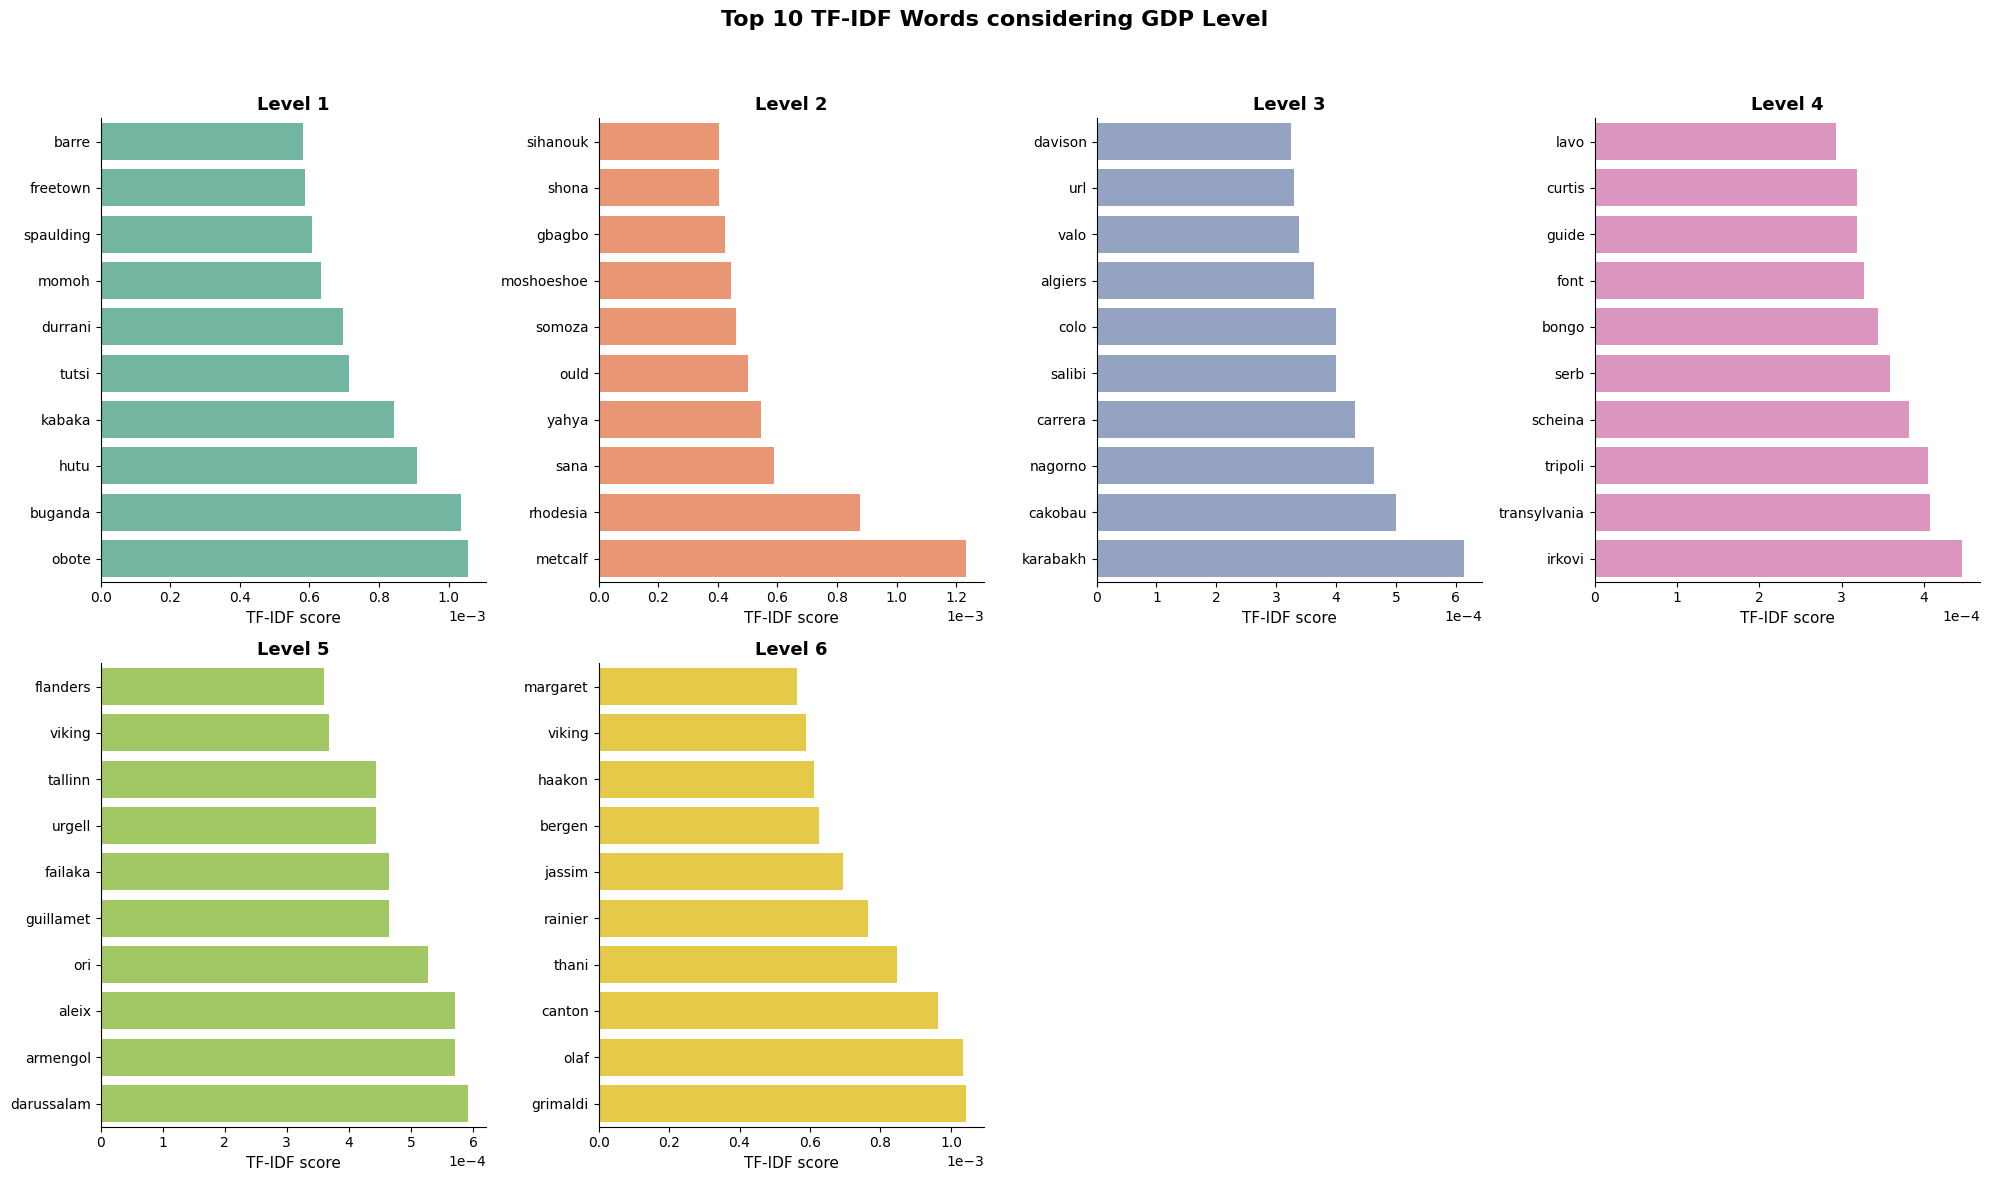

In [243]:
plot_tfidf_bars(tfidf_gdp, label_type="GDP Level", save_path="plots/tfidf_gdp.png")

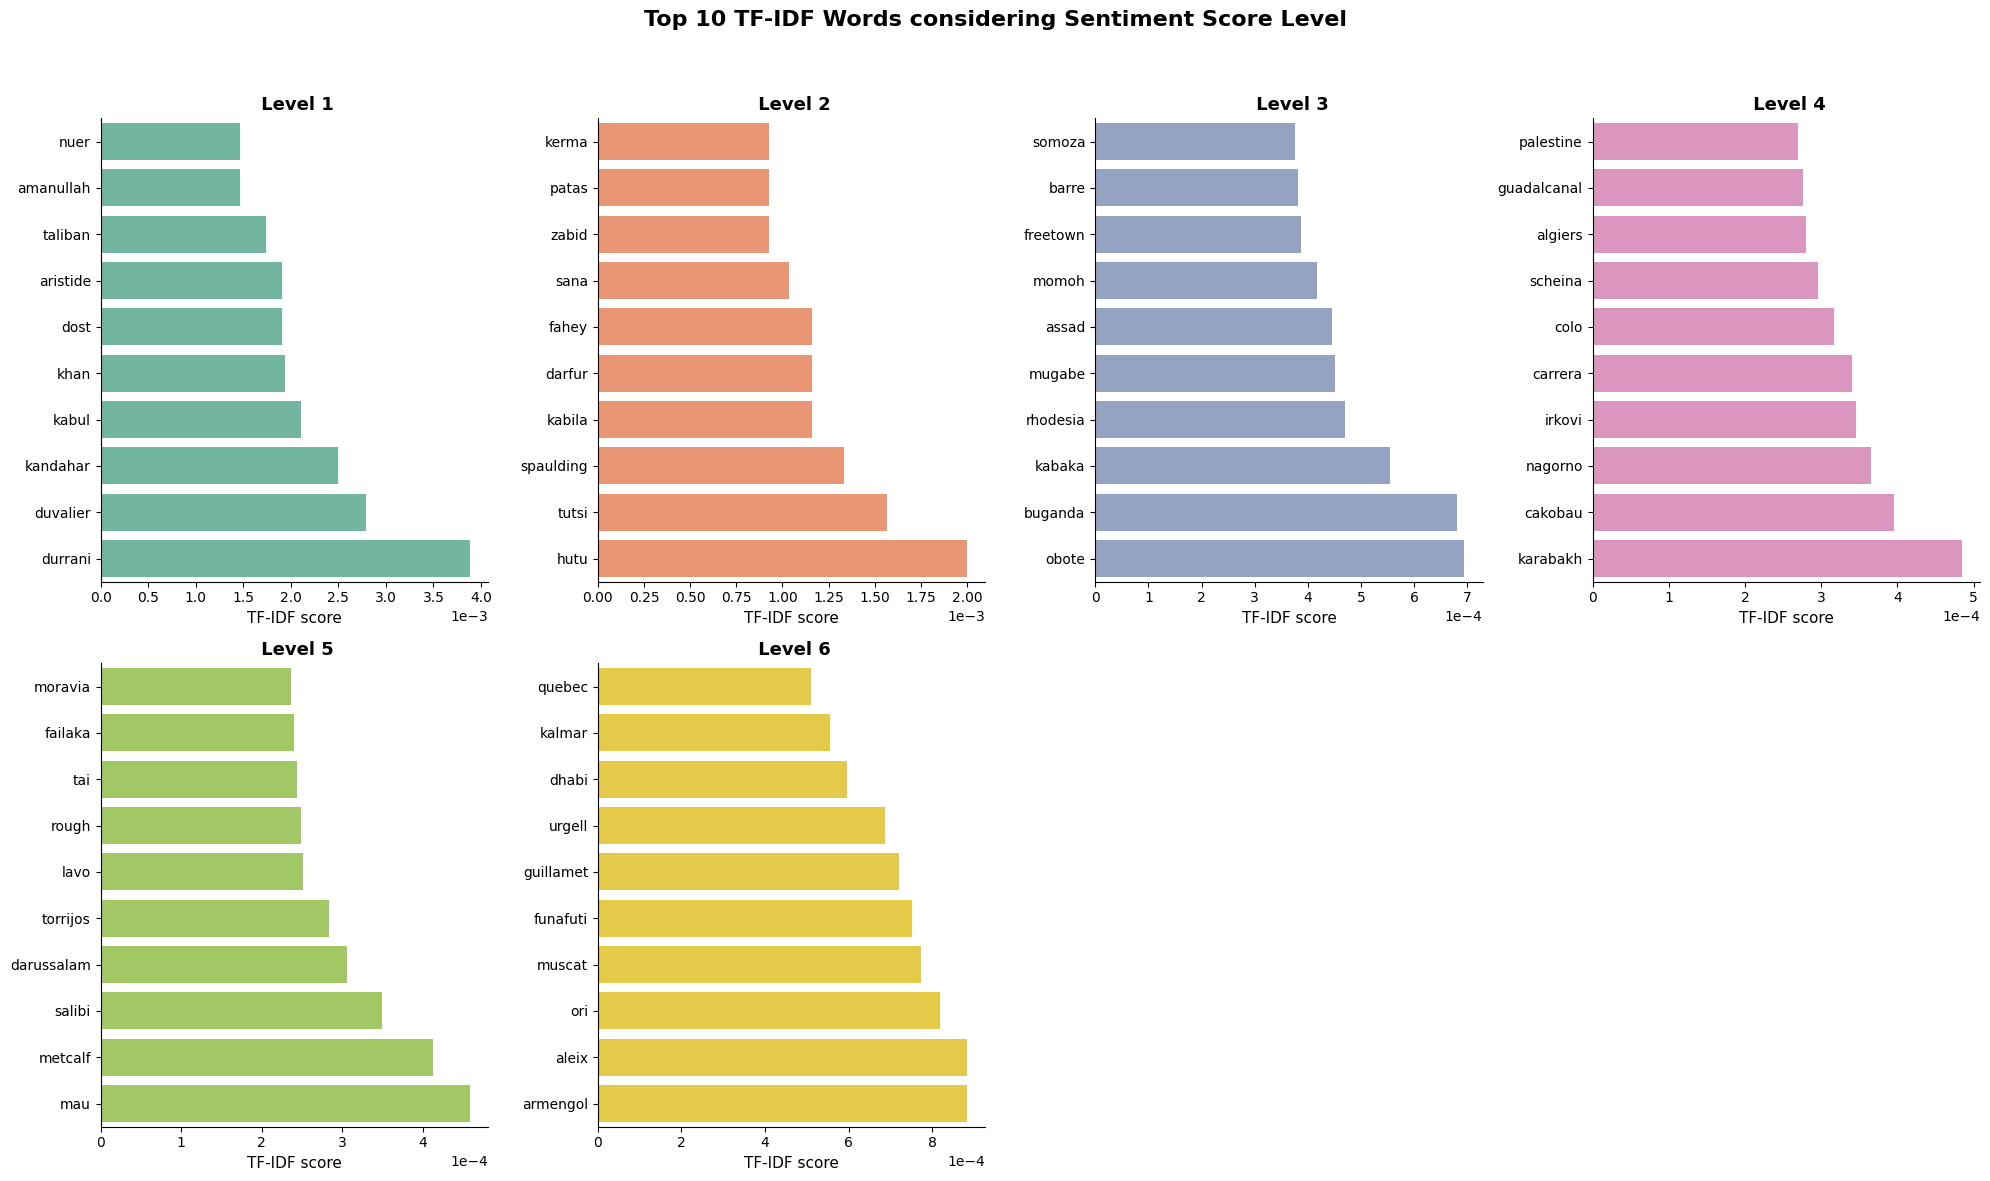

In [244]:
plot_tfidf_bars(tfidf_sentiment, label_type="Sentiment Score Level", save_path="plots/tfidf_sentiment.png")

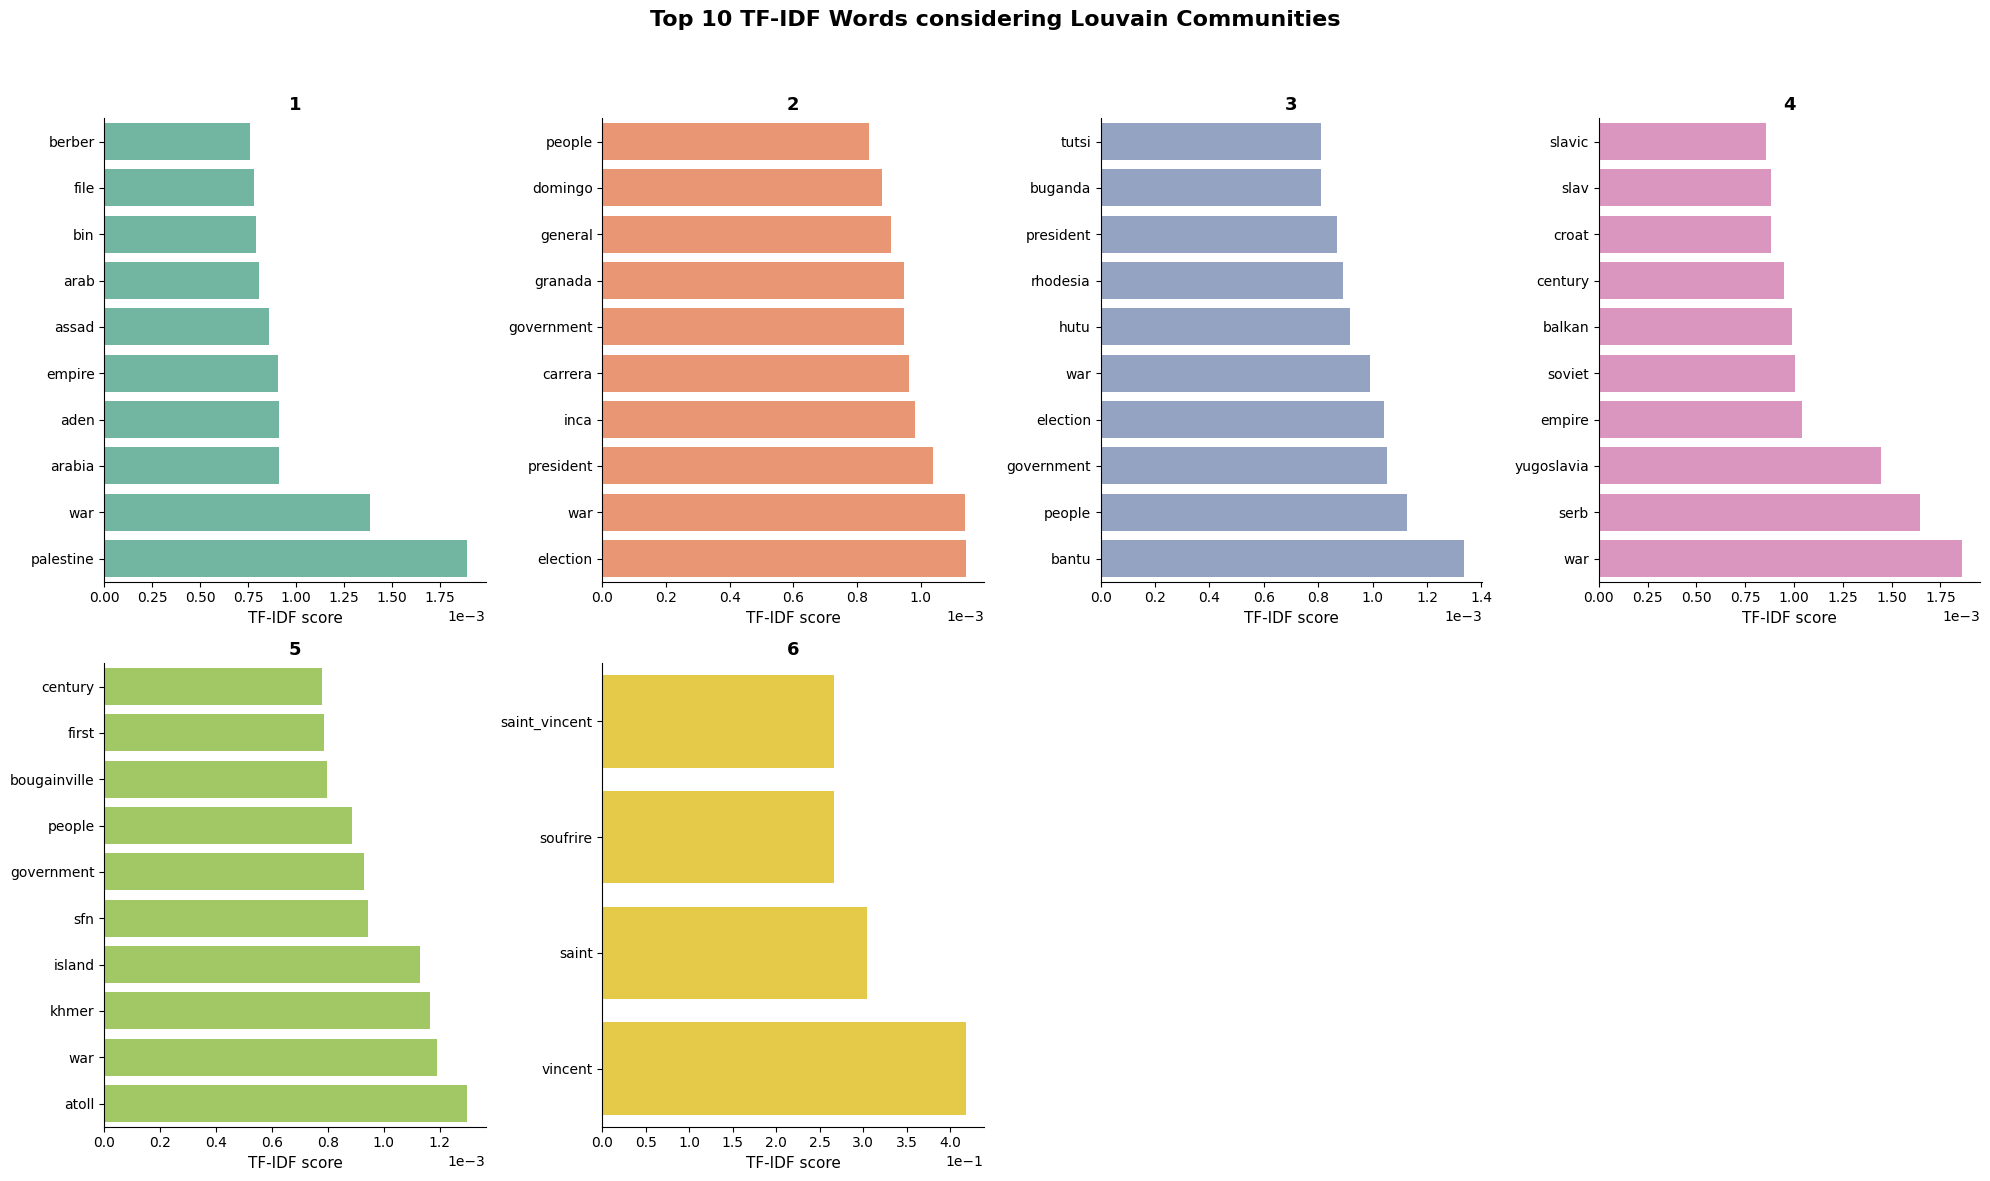

In [245]:
plot_tfidf_bars(tfidf_louvain, label_type="Louvain Communities", save_path="plots/tfidf_louvain.png")


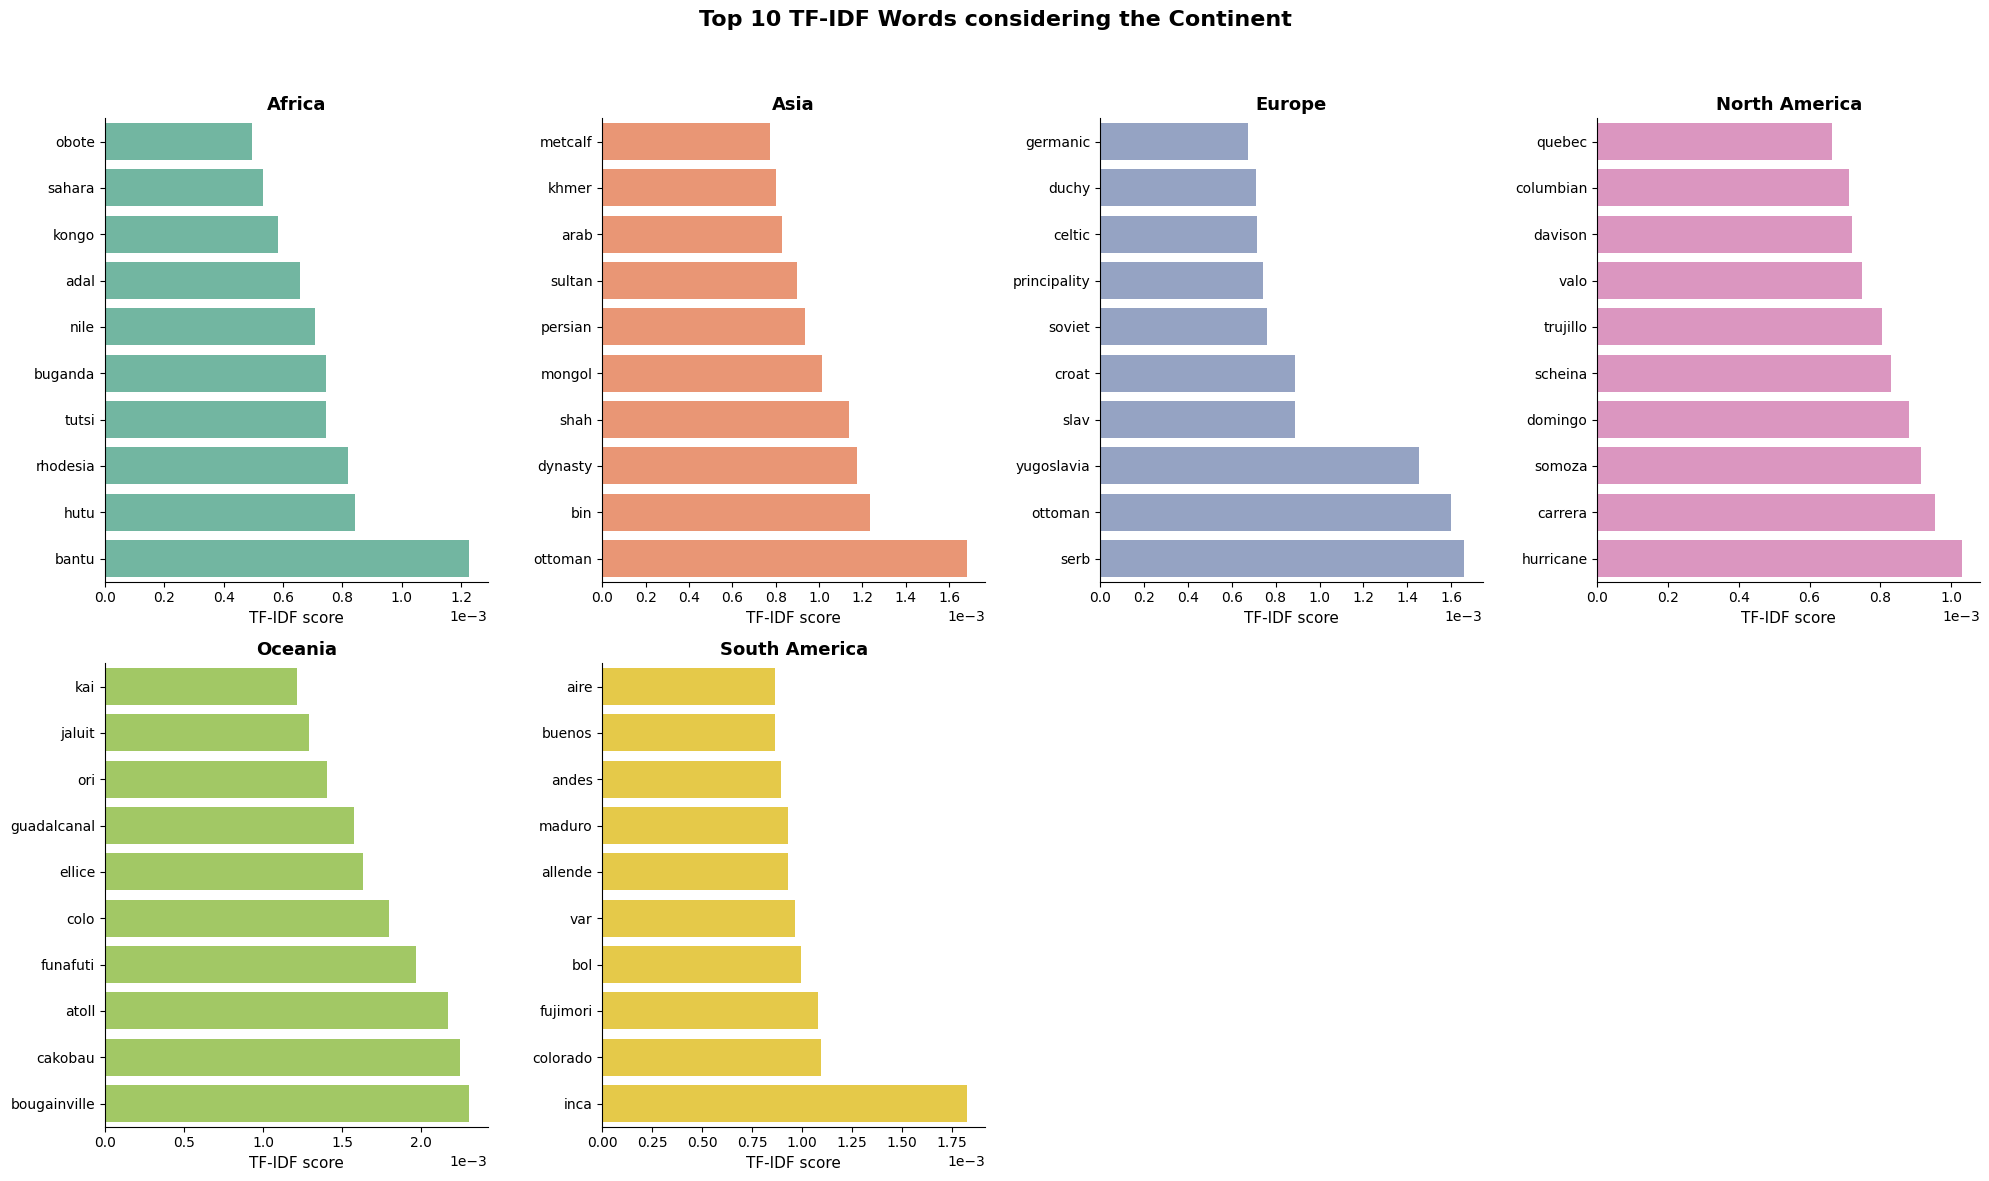

In [230]:
plot_tfidf_bars(tfidf_continent, label_type="the Continent", save_path="plots/tfidf_continent.png")


### Word-Clouds

In [197]:
def create_wordclouds(group_tfidf, out_folder, max_words=100):
    """
    Create and save word clouds for each community/group based on TF-IDF scores.

    Parameters
    group_tfidf : dict
        Dict from compute_tfidf(): {group_name: {word: tfidf_value}}
    out_folder : str or Path
        Folder where the PNG files will be saved
    max_words : int
        Maximum number of words in each word cloud

    Returns
    None
    """
    out_folder = Path(out_folder)
    out_folder.mkdir(exist_ok=True)

    for group_name, tfidf_scores in group_tfidf.items():
        if not tfidf_scores:
            continue

        # Normalize values (to help visual scaling)
        max_val = max(tfidf_scores.values())
        freqs = {word: score / max_val for word, score in tfidf_scores.items()}

        # Create world-cloud 
        wc = WordCloud(
            width=1200,
            height=800,
            background_color="white",
            max_words=max_words,
            colormap="viridis",
            random_state=42
        ).generate_from_frequencies(freqs)

        # Save figure
        plt.figure(figsize=(10, 6))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        out_path = out_folder / f"{group_name}_wordcloud.png"
        plt.tight_layout()
        plt.savefig(out_path, dpi=300)
        plt.close()

In [82]:
create_wordclouds(tfidf_gdp, "wordclouds_gdp_level")

In [83]:
create_wordclouds(tfidf_sentiment, "wordclouds_sentiment_score_level")

In [84]:
create_wordclouds(tfidf_louvain, "wordclouds_louvain")

In [198]:
create_wordclouds(tfidf_continent, "wordclouds_continent")

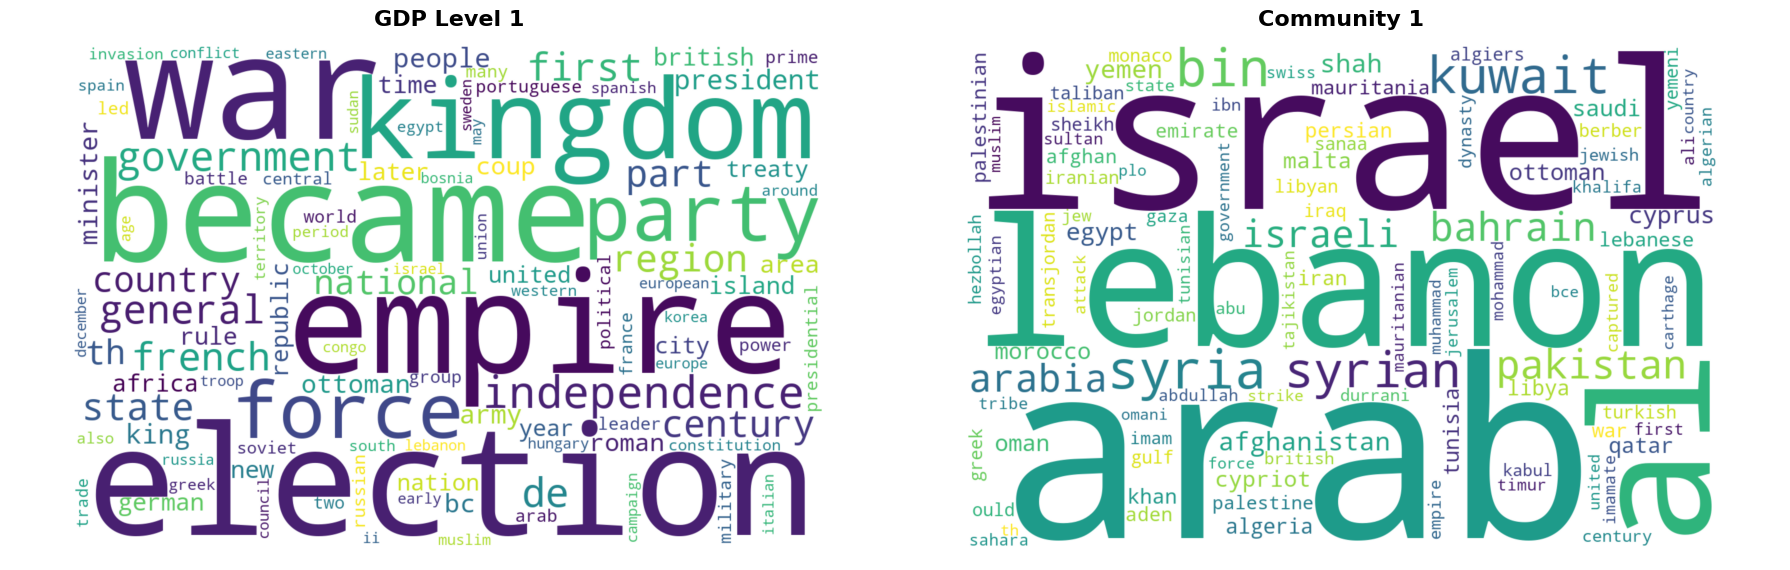

In [125]:
# image paths 
img1 = Path("wordclouds_gdp_level\LEVEL_1_wordcloud.png")     
img2 = Path("wordclouds_louvain/1_wordcloud.png")      

titles = [ "GDP Level 1", "Community 1"]

# Plot them side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for ax, img_path, title in zip(axes, [img1, img2], titles):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(title, fontsize=16, weight="bold")

plt.tight_layout()
plt.show()